In [ ]:
import pandas as pd
import numpy as np
from matplotlib.pylab import plt
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from datetime import datetime
dateTime = lambda self: self.now().strftime("%d-%b-%Y (%H:%M:%S.%f)")

In [227]:
%run def_plots.ipynb

In [ ]:
df_init=pd.read_excel('data/demetra_ipp_1_2020.xlsx',sheet_name='t_ch',skiprows=1)
df_init=df_init[['CA','DF','DG']].dropna()
my_dates=pd.date_range(start='2001-01-31',periods=len(df_init),freq='M')
df_init.index=my_dates
df_init.plot(figsize=(16,4))

In [2]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
scl = StandardScaler()
df_init_scal = scl.fit_transform(df_init.values)#сохраняем мат и дисп для скал тестовой выборки

In [4]:
df_init_scal

array([[-2.73521124e-01, -1.21215339e+00, -4.77394606e-01],
       [-2.04476425e-01, -8.97536165e-01, -4.04314595e-01],
       [-2.22553481e-01, -5.81726444e-01, -2.49304259e-01],
       [-1.18007010e-01, -3.02750541e-01,  2.88603340e-02],
       [ 1.35418697e-01,  2.06567630e-03,  3.16630594e-01],
       [ 2.87601250e-01,  2.48909680e-01,  4.53075628e-01],
       [ 3.37384636e-01,  2.99308280e-01,  4.90282959e-01],
       [ 4.29383223e-01,  2.44035517e-01,  5.94622981e-01],
       [ 4.69579029e-01,  2.71227691e-01,  7.27976701e-01],
       [ 4.29372540e-01,  4.28359805e-01,  7.63145145e-01],
       [ 4.34307226e-01,  5.54528472e-01,  7.16584519e-01],
       [ 3.64045967e-01,  4.66200785e-01,  6.74082470e-01],
       [ 2.12610060e-01,  2.57620461e-01,  7.02821261e-01],
       [ 1.27238992e-01,  8.92179799e-02,  7.61364840e-01],
       [ 8.82578364e-02, -2.88180075e-02,  7.18541587e-01],
       [ 9.84393419e-02, -1.15358417e-01,  5.76413206e-01],
       [ 5.31744854e-02, -2.43318405e-01

In [5]:
def prep_data(ncol):
    a=df_init_scal[:,ncol].reshape(230,1)
    b=np.roll(df_init_scal[:,ncol],-1).reshape(230,1)
    return np.hstack([a,b])

In [6]:
data_sep=200
print('точка разделения данных: {}'.format(my_dates[data_sep]))
n_steps=6
X_cnn,y_cnn=split_sequences(prep_data(0), n_steps)
print('размерность не разбитой выборки:',X_cnn.shape, y_cnn.shape)
print()
print('размерность преобразованных тренировочных данных для снн с окном', n_steps,'равна',X_cnn[:data_sep-n_steps+2].shape, y_cnn[:data_sep-n_steps+2].shape)
X_cnn_train1=X_cnn[:data_sep-n_steps+2]
X_cnn_test1=X_cnn[data_sep-n_steps+1:]
print('размерность тестовых данных равна',X_cnn_test1.shape)
y_cnn_train1=y_cnn[:data_sep-n_steps+2]
y_cnn_test1=y_cnn[data_sep-n_steps+1:]

точка разделения данных: 2017-09-30 00:00:00
размерность не разбитой выборки: (225, 6, 1) (225,)

размерность преобразованных тренировочных данных для снн с окном 6 равна (196, 6, 1) (196,)
размерность тестовых данных равна (30, 6, 1)


In [7]:
def prep_data_2(stacked,n_steps=n_steps,data_sep=data_sep):
        X,y=split_sequences(stacked, n_steps)
        X_train=X[:data_sep-n_steps+2]
        X_test=X[data_sep-n_steps+1:]
        y_train=y[:data_sep-n_steps+2]
        y_test=y[data_sep-n_steps+1:]
        return X_train,X_test,y_train,y_test

In [8]:
X_train1,X_test1,y_train1,y_test1=prep_data_2(prep_data(0))
X_train2,X_test2,y_train2,y_test2=prep_data_2(prep_data(1))
X_train3,X_test3,y_train3,y_test3=prep_data_2(prep_data(2))


In [68]:
x = np.arange(20).reshape(2, 10)
x.shape

(2, 10)

In [70]:
y = np.arange(20).reshape(2, 10)

In [75]:
# from tensorflow.keras.layers import Concatenate
Concatenate(axis=1)([x, y])

<tf.Tensor 'concatenate_5_1/concat:0' shape=(2, 20) dtype=int64>

In [144]:
from keras.models import Sequential, Model 
from matplotlib import pyplot
from keras.layers import LeakyReLU

from keras.models import Model 
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers import LSTM, GRU
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
import keras.backend as K
def size(model): # Compute number of params in a model (the actual number of floats)
    return sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])

In [82]:
# def my_stack_cnn()
n_features1,n_features2,n_features3= X_train1.shape[2],X_train2.shape[2],X_train3.shape[2]


ipp_1 = Input(shape=(n_steps, n_features1),name='fact_ipp_1')
ipp_2 = Input(shape=(n_steps, n_features2),name='fact_ipp_2')
ipp_3 = Input(shape=(n_steps, n_features3),name='fact_ipp_3')

cnn1 = Conv1D(filters=2, kernel_size=4, activation='relu',activity_regularizer=regularizers.l2(0.01))(ipp_1)
cnn2 = Conv1D(filters=2, kernel_size=4, activation='relu',activity_regularizer=regularizers.l2(0.01))(ipp_2)
cnn3 = Conv1D(filters=2, kernel_size=4, activation='relu',activity_regularizer=regularizers.l2(0.01))(ipp_3)

merge = concatenate([cnn1, cnn2, cnn3],axis=-1)#что дает -1? не переворачивает ли она вверх ногами матрицу?
merge = Conv1D(filters=1, kernel_size=1, activation='relu',activity_regularizer=regularizers.l2(0.01))(merge)
merge = Flatten()(merge)

ipp_1_pred=Dense(1,activation='linear', name='out_1')(merge)
ipp_2_pred=Dense(1,activation='linear', name='out_2')(merge)
ipp_3_pred=Dense(1,activation='linear', name='out_3')(merge)

model = Model([ipp_1, ipp_2,ipp_3],[ipp_1_pred,ipp_2_pred,ipp_3_pred])


model.compile(optimizer='adam',
              loss={'out_1': 'mse','out_2': 'mse',
                    'out_3': 'mse'},
              
              loss_weights={'out_1': 1,
                            'out_2': 1,
                            'out_3': 1},
            metrics=['mse', 'mae', 'mape'])


In [146]:
# def my_stack_lstm()
n_features1,n_features2,n_features3= X_train1.shape[2],X_train2.shape[2],X_train3.shape[2]


ipp_1 = Input(shape=(n_steps, n_features1),name='fact_ipp_1')
ipp_2 = Input(shape=(n_steps, n_features2),name='fact_ipp_2')
ipp_3 = Input(shape=(n_steps, n_features3),name='fact_ipp_3')


lstm1=LSTM(3, activation='relu', input_shape=(n_steps, n_features1))(ipp_1)
lstm2=LSTM(3, activation='relu', input_shape=(n_steps, n_features2))(ipp_2)
lstm3=LSTM(3, activation='relu', input_shape=(n_steps, n_features3))(ipp_3)


merge = concatenate([lstm1, lstm2, lstm3],axis=-1)

# merge=Reshape((5,3))(merge)
# merge = Flatten()(merge)

ipp_1_pred=Dense(1,activation='linear', name='out_1')(merge)
ipp_2_pred=Dense(1,activation='linear', name='out_2')(merge)
ipp_3_pred=Dense(1,activation='linear', name='out_3')(merge)

model = Model([ipp_1, ipp_2,ipp_3],[ipp_1_pred,ipp_2_pred,ipp_3_pred])


model.compile(optimizer='adam',
              loss={'out_1': 'mse','out_2': 'mse',
                    'out_3': 'mse'},
              
              loss_weights={'out_1': 1,
                            'out_2': 1,
                            'out_3': 1},
            metrics=['mse', 'mae', 'mape'])


In [158]:
# def my_stack_gru()
n_features1,n_features2,n_features3= X_train1.shape[2],X_train2.shape[2],X_train3.shape[2]


ipp_1 = Input(shape=(n_steps, n_features1),name='fact_ipp_1')
ipp_2 = Input(shape=(n_steps, n_features2),name='fact_ipp_2')
ipp_3 = Input(shape=(n_steps, n_features3),name='fact_ipp_3')


gru1=GRU(3, activation='relu', input_shape=(n_steps, n_features1))(ipp_1)
gru2=GRU(3, activation='relu', input_shape=(n_steps, n_features2))(ipp_2)
gru3=GRU(3, activation='relu', input_shape=(n_steps, n_features3))(ipp_3)


merge = concatenate([gru1, gru2, gru3],axis=-1)

# merge=Reshape((5,3))(merge)
# merge = Flatten()(merge)

ipp_1_pred=Dense(1,activation='linear', name='out_1')(merge)
ipp_2_pred=Dense(1,activation='linear', name='out_2')(merge)
ipp_3_pred=Dense(1,activation='linear', name='out_3')(merge)

model = Model([ipp_1, ipp_2,ipp_3],[ipp_1_pred,ipp_2_pred,ipp_3_pred])


model.compile(optimizer='adam',
              loss={'out_1': 'mse','out_2': 'mse',
                    'out_3': 'mse'},
              
              loss_weights={'out_1': 1,
                            'out_2': 1,
                            'out_3': 1},
            metrics=['mse', 'mae', 'mape'])


In [159]:
size(model)

255

In [160]:
print ('Отношение числа наблюдений к кол-ву оцениваемых параметров в одной ветке: {}'\
       .format(round((X_cnn_train1.shape[0]*X_cnn_train1.shape[1])/size(model),2)))

Отношение числа наблюдений к кол-ву оцениваемых параметров в одной ветке: 4.61


In [161]:
history=model.fit({'fact_ipp_1': X_train1, 'fact_ipp_2': X_train2,'fact_ipp_3': X_train3},
          {'out_1':y_train1,'out_2':y_train2,'out_3':y_train3},
                  validation_data=({'fact_ipp_1': X_test1, 'fact_ipp_2': X_test2,'fact_ipp_3': X_test3},
          {'out_1':y_test1,'out_2':y_test2,'out_3':y_test3}),
          epochs=200, batch_size=100,verbose=0)

In [221]:
# def simple_gru(IPP)
n_features1= X_train1.shape[2]


ipp_1 = Input(shape=(n_steps, n_features1),name='fact_ipp_1')
gru1=GRU(3, activation='relu', input_shape=(n_steps, n_features1))(ipp_1)
ipp_1_pred=Dense(1,activation='linear', name='out_1')(gru1)

model = Model([ipp_1],[ipp_1_pred])

model.compile(optimizer='adam',
              loss={'out_1': 'mse'},

            metrics=['mse', 'mae', 'mape'])

history=model.fit({'fact_ipp_1': X_train1},
          {'out_1':y_train1},
                  validation_data=({'fact_ipp_1': X_test1},
          {'out_1':y_test1}),
          epochs=200, batch_size=100,verbose=0)


In [225]:
# with_rolling


def with_rolling(model, X_train1, y_train1, X_test1, y_test1):
    y_hat=np.array([])
    for i in range(0,len(y_test1)):
        history=model.fit({'fact_ipp_1': X_train1},
          {'out_1':y_train1},
#                   validation_data=({'fact_ipp_1': X_test1},
#           {'out_1':y_test1}),
          epochs=200, batch_size=100,verbose=0)
        y_hat=np.hstack([y_hat,model.predict(X_test1[i].reshape(1,6,1))[0]])
        X_train1=np.concatenate((X_train1,X_test1[i].reshape(1,6,1)))
    return y_hat
        
    

In [220]:
with_rolling(model, X_train1, y_train1, X_test1, y_test1)

array([-0.04070785, -0.00949564, -0.00498016, -0.00305955, -0.00228509,
        0.00383602, -0.03980487, -0.02314835, -0.01549102, -0.01796917,
       -0.01023932, -0.01129881, -0.01461415, -0.00952789, -0.01249505,
       -0.00585038, -0.00584331, -0.00576518, -0.00782466, -0.00666539,
       -0.00447607, -0.00482925, -0.00328324, -0.00438489, -0.00368199,
        0.0028483 ,  0.0031221 , -0.00146654,  0.01153096])

In [224]:
y_test1

array([ 0.34473438,  0.37176267,  0.39472031,  0.31374106,  0.09076421,
       -0.05694968, -0.12126816, -0.19631503, -0.24495968, -0.2557269 ,
       -0.27348064, -0.28284397, -0.25155332, -0.21778903, -0.19950576,
       -0.09842583,  0.09537026,  0.22044542,  0.26875814,  0.28552293,
        0.28192138,  0.2788021 ,  0.27292762,  0.27899285,  0.2527489 ,
        0.22045863,  0.22073713,  0.19183924,  0.19044269, -0.27352112])

Берем ариму , ищем акаиком макс лаг
Как связаны отрасли
у нас есть добыча пол, произв бенз, химия

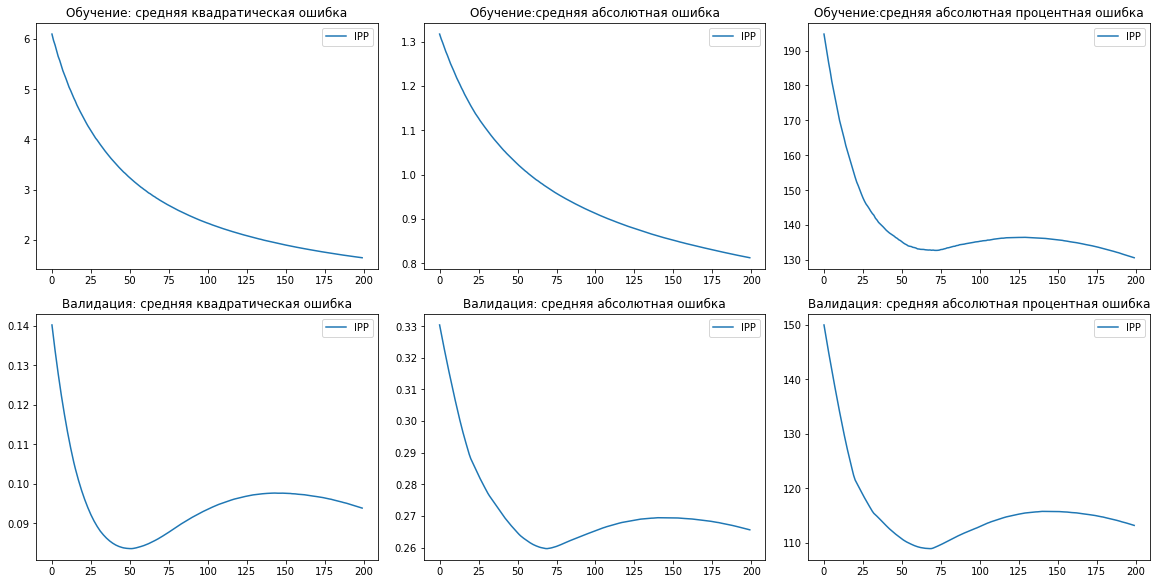

In [178]:
plot_metrics_unique(history,save=False,comment='a',mylable='IPP')

KeyError: 'out_1_mean_squared_error'

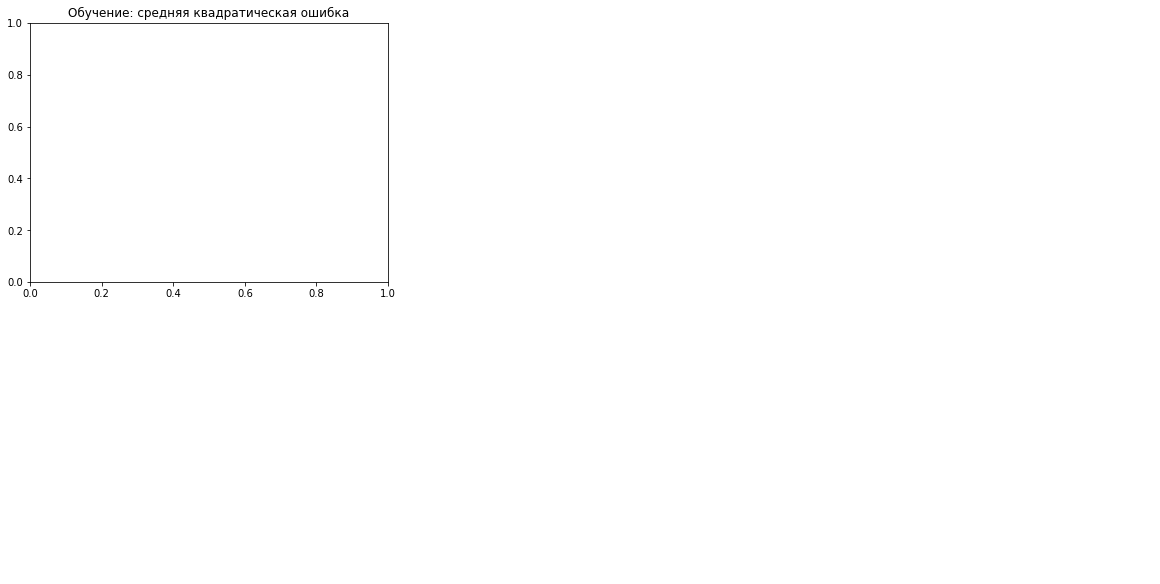

In [167]:
plot_metrics(history,save=False,comment='a')

In [155]:
predict=np.hstack(model.predict([X_test1,X_test2,X_test3]))
pred_inv=scl.inverse_transform(predict)#восстановить прогнозное значение ряда, только нужно для последнего ряда
init_test=df_init[my_dates[data_sep]:]

pred_df=pd.DataFrame(pred_inv,index=init_test.index,columns=init_test.columns)

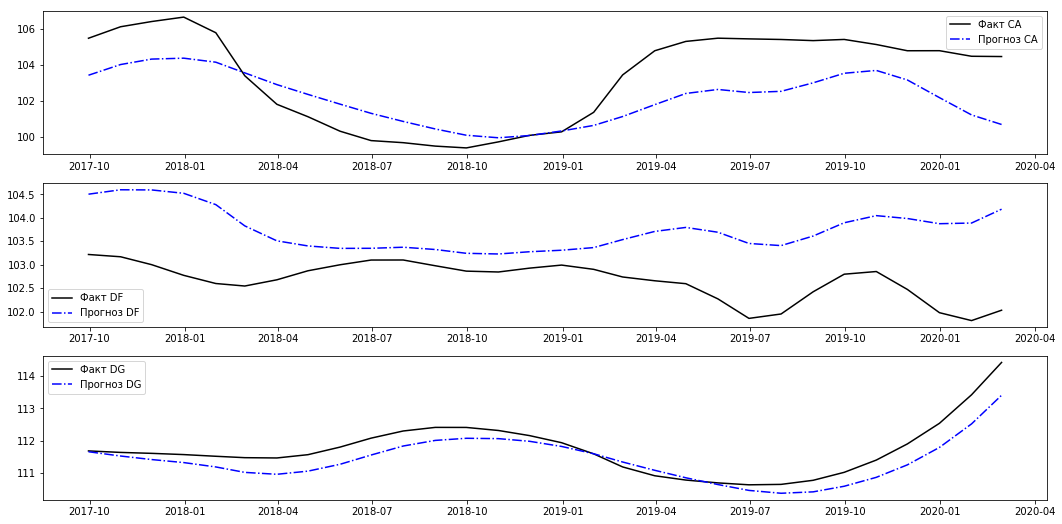

In [156]:
fig2 = plt.figure(figsize=(18, 9))
spec2 = gridspec.GridSpec(ncols=1, nrows=3, figure=fig2)
ax1 = fig2.add_subplot(spec2[0, 0])
ax1.plot(init_test.CA, color='black', label = 'Факт CA')
ax1.plot(pred_df.CA,'-.', color='blue', label = 'Прогноз CA')
ax1.legend(loc='best')
ax2 = fig2.add_subplot(spec2[1, 0])
ax2.plot(init_test.DF, color='black', label = 'Факт DF')
ax2.plot(pred_df.DF,'-.', color='blue', label = 'Прогноз DF')
ax2.legend(loc='best')
ax3 = fig2.add_subplot(spec2[2, 0])
ax3.plot(init_test.DG, color='black', label = 'Факт DG')
ax3.plot(pred_df.DG,'-.', color='blue', label = 'Прогноз DG')
ax3.legend(loc='best')

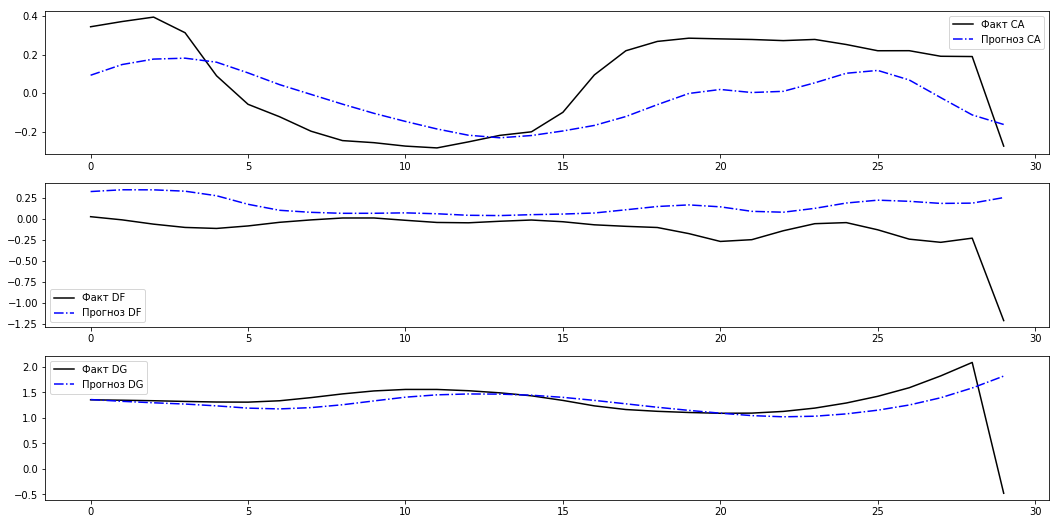

In [157]:
pred1,pred2,pred3=model.predict([X_test1,X_test2,X_test3])
fig2 = plt.figure(figsize=(18, 9))
spec2 = gridspec.GridSpec(ncols=1, nrows=3, figure=fig2)
ax1 = fig2.add_subplot(spec2[0, 0])
ax1.plot(y_test1, color='black', label = 'Факт CA')
ax1.plot(pred1,'-.', color='blue', label = 'Прогноз CA')
ax1.legend(loc='best')
ax2 = fig2.add_subplot(spec2[1, 0])
ax2.plot(y_test2, color='black', label = 'Факт DF')
ax2.plot(pred2,'-.', color='blue', label = 'Прогноз DF')
ax2.legend(loc='best')
ax3 = fig2.add_subplot(spec2[2, 0])
ax3.plot(y_test3, color='black', label = 'Факт DG')
ax3.plot(pred3,'-.', color='blue', label = 'Прогноз DG')
ax3.legend(loc='best')

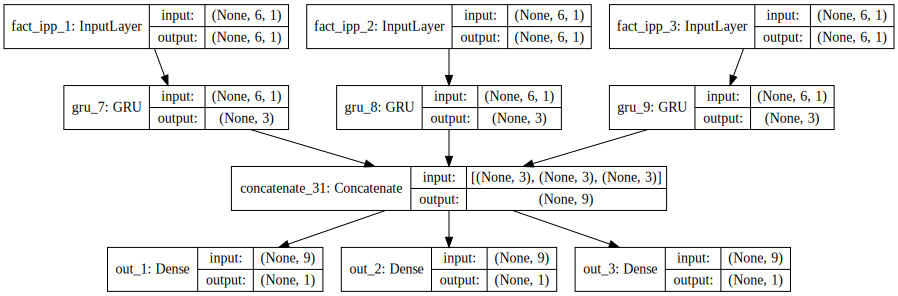

In [150]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [151]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fact_ipp_1 (InputLayer)         (None, 6, 1)         0                                            
__________________________________________________________________________________________________
fact_ipp_2 (InputLayer)         (None, 6, 1)         0                                            
__________________________________________________________________________________________________
fact_ipp_3 (InputLayer)         (None, 6, 1)         0                                            
__________________________________________________________________________________________________
gru_7 (GRU)                     (None, 3)            45          fact_ipp_1[0][0]                 
__________________________________________________________________________________________________
gru_8 (GRU

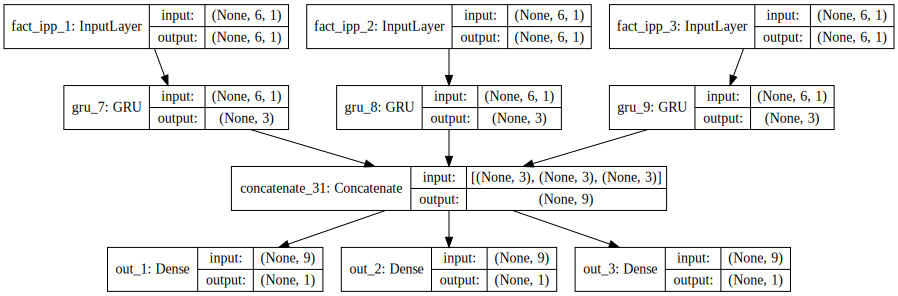

In [151]:
model.summary()
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
